In [6]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from fbg import *
from scipy.signal import find_peaks

In [7]:
filepath = 'spectra_files/psg_trn.txt'
data = psg_to_numpy(filepath, verbose=False)

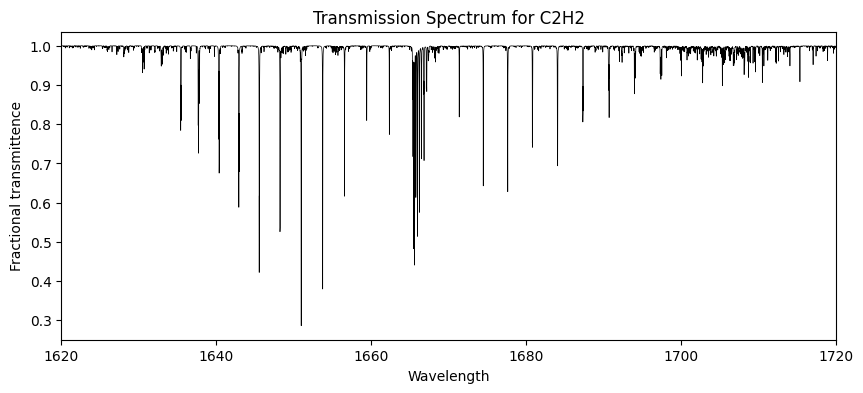

In [8]:
wavelength = data[:,0]*1e3

plt.figure(figsize=(10,4))
plt.plot(wavelength, data[:,1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for C2H2')
plt.xlim((1620,1720))
plt.show()

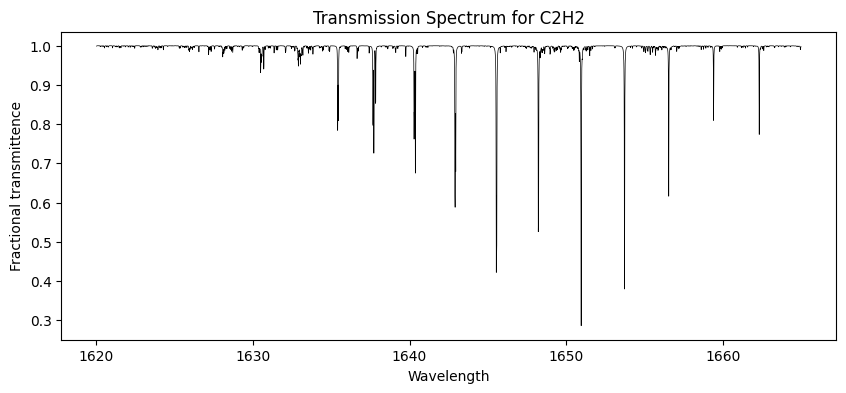

In [9]:
index_array =  np.where((wavelength>1620) & (wavelength<=1665)) # 1720
index = index_array[0]

plt.figure(figsize=(10,4))
plt.plot(wavelength[index], data[index,1], color='black', linewidth=0.5)
plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for C2H2')
plt.show()

Locate peaks with minimal distance between peaks to eliminate split peaks

[1.62001  0.998889 0.998889]
[1.62001e+03 9.98889e-01 9.98889e-01]
[1.620577e+03 9.988890e-01 9.988890e-01]
1620.5770035


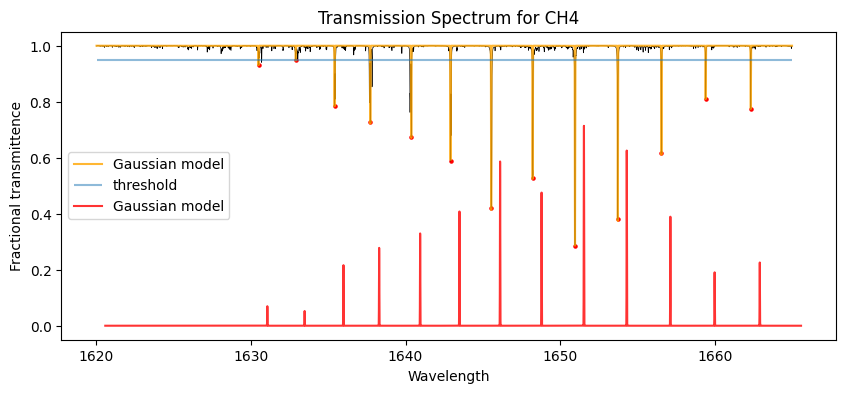

In [10]:
subset = data[index,:]
print(subset[0])

# convert wavelength into nm
subset[:,0] = subset[:,0] * 1e3


plt.show()
plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5)



threshold_value = 0.95
peaks = locate_peaks(subset[:, 1], threshold=threshold_value, distance=100) # distance=100 correspond to 1nm
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, n=10000, sigma=1e-2, type='Gaussian')
plt.scatter(subset[peaks, 0], subset[peaks, 1], color='red', s=5)
plt.plot(wavelength_gauss, trans_gauss, color='orange', alpha=0.8, label='Gaussian model')
plt.hlines(threshold_value, subset[:, 0].min(), subset[:, 0].max(), alpha=0.5, label='threshold')
print(subset[0])

# add strain
strain = 500
subset = apply_strain(subset, strain)
wavelength_gauss, trans_gauss = generate_spectrum(subset, peaks, n=10000, sigma=1e-2, type='Gaussian')
plt.plot(wavelength_gauss, 1-trans_gauss, color='red', alpha=0.8, label='Gaussian model')

print(subset[0])
print(wavelength_gauss[0])

plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')
plt.legend()
# plt.xlim((1620,1625))
plt.show()


Re-define function generate_spectrum_strain to include tension tuning.

Since we have $\Delta \lambda / \lambda \sim 7*10^{-1} \sigma$, where $\sigma$ is in unit of micro-strain ($\mu\epsilon$),

then, we can have $\lambda_{new} \sim (1 + 7*10^{-7} * \sigma) * \lambda$. Now, $\sigma$ is in unit of strain ($\epsilon$).

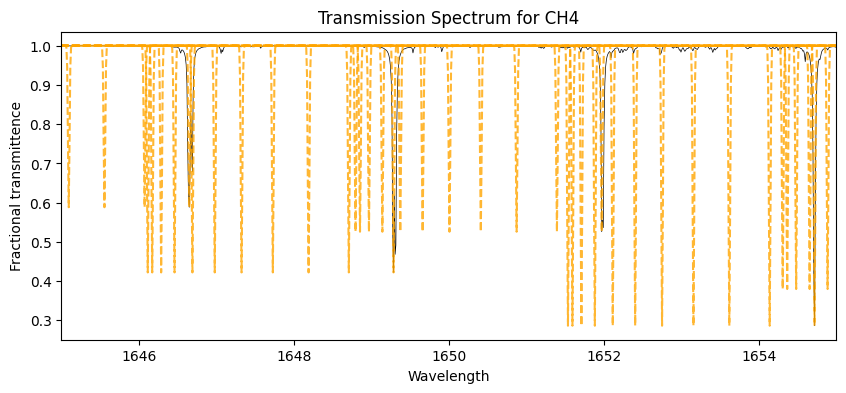

In [11]:
step = 11
strain = np.linspace(0, 500, step)
j = 0
wavelength_gauss = np.zeros((len(index),step))
trans_gauss = np.zeros((len(index),step))


for i in strain: 
    subset = apply_strain(subset, i)
    wavelength_gauss[:,j], trans_gauss[:,j] = generate_spectrum(subset, peaks, n=len(index), sigma=1e-2, type='Gaussian')
    j = j + 1

plt.figure(figsize=(10,4))
plt.plot(subset[:, 0], subset[:,1], color='black', linewidth=0.5, label='Original transmission spectrum')
j=0
for j in range(step):
    plt.plot(wavelength_gauss[:,j], trans_gauss[:,j], color='orange', linestyle='dashed', alpha=0.8, label='Gaussian model')

plt.xlabel('Wavelength')
plt.ylabel('Fractional transmittence')
plt.title('Transmission Spectrum for CH4')


plt.xlim((1645.0,1655.0))

plt.show()

Now, we can compute cross-correlation for different tension (strain).

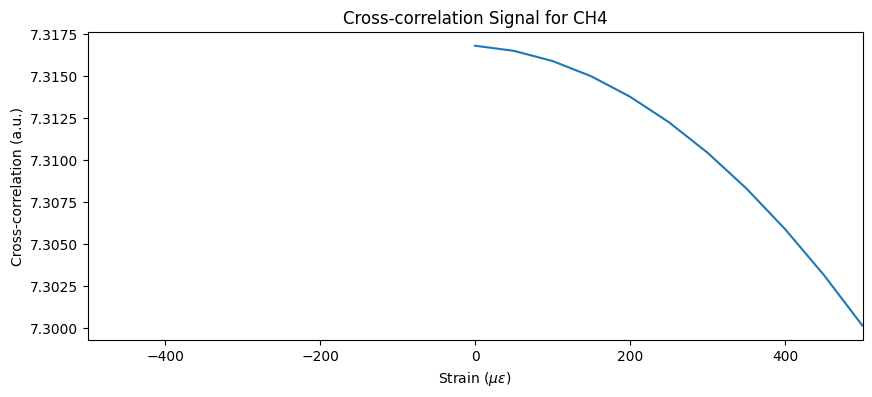

In [12]:
corss_correlation = np.zeros((step,1))

j=0
for j in range(step):
    corss_correlation[j,:] = np.sum(np.multiply((1-trans_gauss[:,j]), subset[:,1]))


plt.figure(figsize=(10,4))
plt.plot(strain, corss_correlation)
plt.xlabel('Strain ($\mu\epsilon$)')
plt.ylabel('Cross-correlation (a.u.)')
plt.title('Cross-correlation Signal for CH4')
plt.xlim((-500,500))
# plt.ylim((0,1000))
plt.show()